In [1]:
import cooler
import numpy as np
import bioframe
import pandas as pd
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# source of inspiration and copy/paste: https://github.com/mirnylab/cooltools/blob/master/cooltools/coverage.py


# some black 'argparse' magic to make cool2RangeCisPercent.py work as a module ...
import sys
sys.argv = ["cool2RangeCisPercent.py",'-i /home/venevs/houda_test/pairs/validpairs.cool',"-r 6000000","-n 10"]

# other option would be to convince Tyler (original creator) to hid argparse business either inside main()
# or under the __name__ == __main__ section ...

# importing some cooler pixels streaming functions here:
from cool2RangeCisPercent import _zero_diags, \
                                 _zero_range, \
                                 _timesouterproduct, \
                                 _get_chunk_coverage_cis, \
                                 _get_mask
# 0-fill diagonal pixels, if any, in a given chunk of pixels
# 0-fill pixels outside the range, if any, in a given chunk of pixels
# multiply raw pixel_ij value by weight_i*weight_j balancing factor
# counts cis coverage
# get a mask of "bad" bins (too close to chrom ends, too many NaNs, fitlered by balancing)


In [3]:
# Tyler's original function (dense matrix approach)
# https://github.com/tborrman/digest-Hi-C/blob/master/hdf2RangeCisPercent.py
# https://github.com/tborrman/digest-Hi-C/blob/master/matrix_functions.py

def tyler_style_cisRange(obs,bin_positions,resolution,r,p):
    """
    Tyler style cisRange calculations ...
    bin_positions  - is actually a table with the chrom identity of every bin
    resolution - bin size
    r - 2* cisRange to be summed up ...
    p - fraction of NaNs allowed (wtf for an ICEd matrix ?!)
    """
    max_NAs = (r/resolution) * p
    dist = int((r/resolution)/2)
    num_bins = len(obs)
    cp_list = []
    nnans = []
    for i, row in enumerate(obs):
        # Check if row is all nan
        if np.all(np.isnan(row)) or np.nansum(row) == 0:
            cp_list.append(np.nan)
            nnans.append(np.nan)
        # Check if at start of genome
        elif i - dist < 0:
            cp_list.append(np.nan)
            nnans.append(np.nan)
        # Check if at end of genome
        elif i + (dist- 1) > num_bins -1:
            cp_list.append(np.nan)
            nnans.append(np.nan)
        # Check if at start of chromosome (upstream range reaches trans)
        elif bin_positions[i] != bin_positions[i-dist]:
            cp_list.append(np.nan)
            nnans.append(np.nan)
        # Check if at end of chromosome (downstream range reaches trans) 
        elif bin_positions[i] != bin_positions[i+(dist-1)]:
                cp_list.append(np.nan)
                nnans.append(np.nan)
        else:
            # # Tyler's original:
            # _left = i-dist
            # _right = i+dist
            # # but they are not symmetric ...
            _left = i-dist
            _right = i+dist+1
            # Check if too many NAs in range window
            num_of_nans = np.sum(np.isnan(row[_left:_right]))
            nnans.append(num_of_nans)
            if num_of_nans > max_NAs:
                cp_list.append(np.nan)
            else:
                cis = np.nansum(row[_left:_right])
                # total = np.nansum(row)
                cp = cis #(cis/total) * 100
                cp_list.append(cp)
    # returning ...
    return cp_list, nnans

## Comparing Tyler's dense matrix approach and cooler-based one below

(1) using `cooler` file try to count cisRange using `cooltools-coverage` way

(2) try Tyler's dense matrix way on a dense matrix dump from the `cooler`

(3) try Tyler's-generated BED file for the corresponding dataset

In [4]:
# cool_path = '/home/venevs/houda_test/HBHiC-K562-MN-Dp-2.40000.cool'
# path = '/home/venevs/houda_test/HBHiCK562DN10-4hDp2.40000.cool'
cool_path = '/home/venevs/houda_test/pairs/validpairs.cool'
# cool_path = '/home/venevs/houda_test/pair_4h/4h_valids.cool'
clr = cooler.Cooler(cool_path)
clr_bins = clr.bins()[:]

### Next operation requires a ton of memory (RAM) ...

In [5]:
# Dump an entire balanced matrix ..
# 40 kb is the highest reasonble resolution to do this ...
cool_mat = clr.matrix(balance=True)[:]
print("Dimensions of the dumped matrix ...")
print(cool_mat.shape)

Dimensions of the dumped matrix ...
(77404, 77404)


In [6]:
# cworld-based calculations by Tyler
bed_path = '/home/venevs/houda_test/HBHiC-K562-MN-DpnII-R1-filter1000__hg19__genome__C-40000-iced_scaleBy_0.41_range6Mb_cispercent.bedGraph'
# bed_path = '/home/venevs/houda_test/HBHiCK562DN10-4h-DpnII-R1-filter1000__hg19__genome__C-40000-iced_scaleBy_0.41_range6Mb_cispercent.bedGraph'

bed_df = bioframe.read_table(bed_path)
# this is questionable operation ...

# shall we turn NaNs to 0-s or not ?!
cworld_bed = bed_df[3].values
# cworld_bed = np.nan_to_num(bed_df[3].values)

In [7]:
# parameters for cisRange calculations ...



# common between Tyler and cooler ...
binsize = clr.info['bin-size']
n_bins = clr.info['nbins']
grange = 3000000

# cooler-specific ones ...
ignore_diags = 0
bias = clr_bins['weight'].values
range_bins=int(grange/binsize)
# chunksize


# Tyler specific ones ...
tyler_grange = 2*grange
NaNsfraction = 0.1
# control the number of NaNs in a row
# even in a balanced matrix - we cross a bunch of NaNs lines ...
bin_chrom_id = clr_bins['chrom'].values

# for the cooler-ones ...
max_NAs = ((tyler_grange/binsize) * NaNsfraction)

#### Running Tyler's dense matrix function on the cooler-dump

In [8]:

# tyler style calculations on our cooler dump ...
cp_list, tyler_nans = tyler_style_cisRange(
                            obs = cool_mat,
                            bin_positions = bin_chrom_id,
                            resolution = binsize,
                            r = tyler_grange,
                            p = NaNsfraction)

cp_list = np.asarray(cp_list,dtype='float')
# shall we turn NaNs to 0-s or not ?!

# cp_list = np.nan_to_num(cp_list)
# cp_list = cp_list

#### Running cooler streaming pixels approach next

In [9]:

# split apply combine ...
chunks = cooler.tools.split(clr, chunksize=int(1e7), map=map, use_lock=False)
chunks = chunks.pipe(_zero_diags, n_diags=ignore_diags)
chunks = chunks.pipe(_zero_range, range_bins=range_bins)

# should we turn NaNs to 0-s ?
_bias = np.nan_to_num(bias)

covs = (
    chunks
        .pipe(_timesouterproduct, bias = _bias)
        .pipe(_get_chunk_coverage_cis, pixel_weight_key="balanced")
        .reduce( np.add, np.zeros(n_bins) )
)


    
# consider dividing this by the total balanced coverage - should by steady 1.0 , but is it ?!

In [10]:
# we can do the same stuff + ignore range bins =0
# and get the double counted main diagonal ...
# this is very inefficient, but whatever:

# split apply combine ...
chunks = cooler.tools.split(clr, chunksize=int(1e7), map=map, use_lock=False)
chunks = chunks.pipe(_zero_range, range_bins=0)
diag = (
    chunks
        .pipe(_timesouterproduct, bias = _bias)
        .pipe(_get_chunk_coverage_cis, pixel_weight_key="balanced")
        .reduce( np.add, np.zeros(n_bins) )
)

# afterwards covs-diag/2 should be the same as clr.maxtrix()[:].sum(axis=0) ...
    

In [11]:
# get a mask of bins that needs to be "dropped" from covs and diags ...

cov_mask = _get_mask(n_bins,max_NAs,bias,clr.chromnames,clr.offset,range_bins)


## Also we could try to run the cli script itself here ...

In [15]:
### Run the `cool2RangeCisPercent.py` implementation of the protocol ...
! python cool2RangeCisPercent.py -i /home/venevs/houda_test/pairs/validpairs.cool

cli_bed = bioframe.read_table('/home/venevs/houda_test/pairs/validpairs_range6Mb_cispercent.bedGraph',header=0)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eb0b88240>,
      dtype=object)

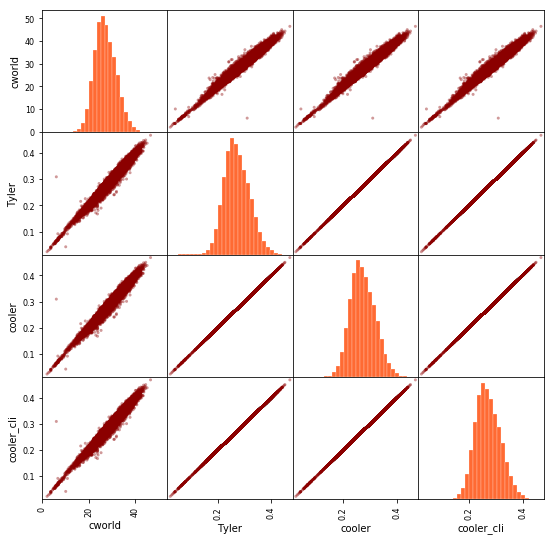

In [19]:
# we need to match chromosomes between Tyler's bed and our results to take out chrY and chrM ...
chrom_mask = clr_bins['chrom'].isin(bed_df[0].unique())


covs_plot = copy(covs-diag/2)
# apply the mask ...
covs_plot[cov_mask] = np.nan

# dummy operation
cp_plot = copy(cp_list)

# cvcv = covs-diag/2
ccc = covs_plot[chrom_mask]
ddd = cp_plot[chrom_mask]
www = cli_bed[chrom_mask]['cisRange']
kkk = cworld_bed


pd.plotting.scatter_matrix(
    pd.DataFrame({"cworld":kkk,"Tyler":ddd,"cooler":ccc,"cooler_cli":www}),
    alpha=0.4,
    figsize=(9,9),
    color='darkred',
    hist_kwds={"bins":30,"color":"orangered","alpha":0.8,"edgecolor":'white', "linewidth":0.3})


looks good to me ...

the difference between Tyler and cworld could be addressed by tweaking how cooler is balancing stuff - skiping double counting the maing diagonal kind of solution ...

### Tyler's calculations - via the BED graph file ...

(-100, 76018)

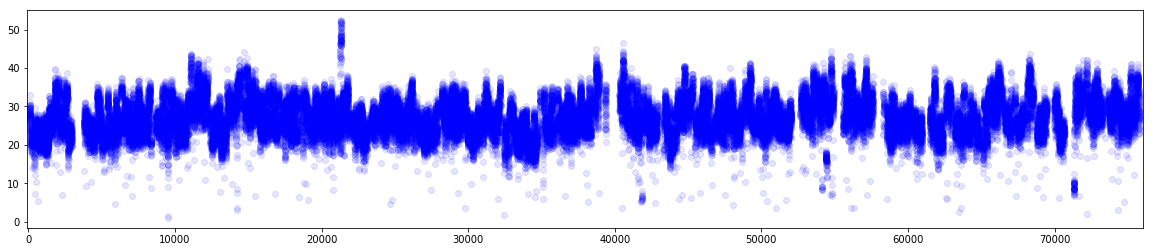

In [13]:
plt.plot(kkk,'bo',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,kkk.size+100)
# plt.gca().set_ylim((0,0.8))

### proper cooler-streaming pixels style calculations `ccc`

(-100, 76018)

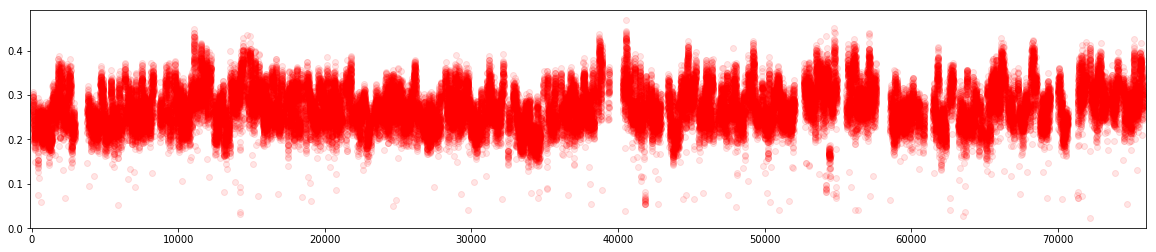

In [14]:
plt.plot(ccc,'ro',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,ccc.size+100)
# plt.gca().set_ylim((0,0.8))